In [86]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [87]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [89]:
# Load the CSV file
df = pd.read_csv('Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [90]:
velocity_dataset.shape

(9455901, 6)

In [91]:
velocity_dataset.head()

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6451203.729,1873252.549,23.31,2.05,1118848075000,515
1,6451203.729,1873252.549,23.31,2.05,1118848075000,515
2,6042814.264,2133542.012,26.54,-0.76,1113437421700,2224
3,6452425.122,1872172.475,37.52,11.20,1118847624800,2127
4,6452347.673,1872258.452,41.99,0.10,1118848324700,1033


In [92]:
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [93]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [94]:
# Count the number of unique vehicle IDs
unique_vehicle_ids = velocity_dataset['Vehicle_ID'].nunique()
print(f"Number of unique vehicle IDs: {unique_vehicle_ids}")

# Count how many rows of data each vehicle ID has
vehicle_counts = velocity_dataset['Vehicle_ID'].value_counts()

# Display the counts of rows for each vehicle ID
print("\nNumber of rows for each vehicle ID:")
print(vehicle_counts)

Number of unique vehicle IDs: 3233

Number of rows for each vehicle ID:
396     8311
705     7508
567     7441
601     7253
468     7206
        ... 
2897     167
2806      78
2815      70
2810      66
2781      60
Name: Vehicle_ID, Length: 3233, dtype: int64


In [95]:
# Access the count for a particular vehicle ID, and create its single dataset
specific_vehicle_id = 396
num_rows = vehicle_counts[specific_vehicle_id]

print(f"The vehicle ID '{specific_vehicle_id}' has {num_rows} rows of data.")

single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == specific_vehicle_id]

The vehicle ID '396' has 8311 rows of data.


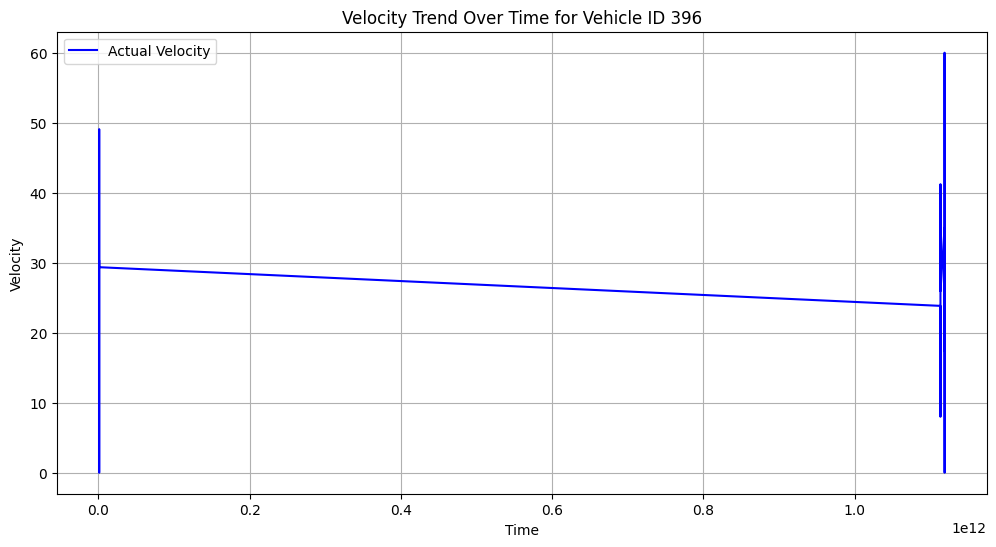

In [96]:
# Extract the time and velocity columns
time = single_vehicle_data['Global_Time'].values
velocity = single_vehicle_data['v_Vel'].values

# Plot the velocity trend over time
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend Over Time for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# # Plot velocity over time
# plt.figure(figsize=(12, 6))
# plt.plot(velocity_dataset_sorted['Global_Time'], velocity_dataset_sorted['v_Vel'], label='Velocity')
# plt.xlabel('Global Time (ms)')
# plt.ylabel('Velocity (v_vel)')
# plt.title('Velocity Evolution Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [98]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # Ensure data is in 2D format (n_samples, n_features)
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names += [f'var1(t-{i})']
        
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        if i == 0:
            names += [f'var1(t)']
        else:
            names += [f'var1(t+{i})']
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [99]:
# Extract the velocity column (assuming 'v_vel' is the velocity column)
velocities = single_vehicle_data['v_Vel'].values

# Convert the velocity time series into a supervised learning problem
n_in = 8  # Number of previous time steps to use as input (8 steps)
n_out = 1  # Number of future time steps to predict (1 step ahead)
supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)

# Time Steps:   t-8   t-7   t-6   t-5   t-4   t-3   t-2   t-1   t
# Values:      [ x ,  x ,  x ,  x ,  x ,  x ,  x ,  x ] -> [ y ]

# Print the first few rows to verify the transformation
print(supervised_data.head())

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8       30.25      30.25      30.25      30.25      30.25      30.25   
9       30.25      30.25      30.25      30.25      30.25      30.24   
10      30.25      30.25      30.25      30.25      30.24      30.24   
11      30.25      30.25      30.25      30.24      30.24      30.24   
12      30.25      30.25      30.24      30.24      30.24      30.24   

    var1(t-2)  var1(t-1)  var1(t)  
8       30.24      30.24    30.24  
9       30.24      30.24    30.24  
10      30.24      30.24    30.23  
11      30.24      30.23    30.23  
12      30.23      30.23    30.23  


In [100]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(supervised_data) * 0.7)
n_validation = int(len(supervised_data) * 0.15)

train_data = supervised_data[:n_train]
validation_data = supervised_data[n_train:n_train + n_validation]
test_data = supervised_data[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_validation, y_validation = validation_data.iloc[:, :-1].values, validation_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

# # Print the shapes of the splits to verify
# print("Training features shape:", X_train)
# print("Training labels shape:", y_train)
# print("Validation features shape:", X_validation)
# print("Validation labels shape:", y_validation)
# print("Test features shape:", X_test)
# print("Test labels shape:", y_test)

In [101]:
# MLP models expect 2D input (samples, features) instead of 3D (samples, time steps, features)
# Reshape the data for MLP (samples, features)
X_train = X_train.reshape((X_train.shape[0], n_in))  # Flatten for MLP
X_validation = X_validation.reshape((X_validation.shape[0], n_in))
X_test = X_test.reshape((X_test.shape[0], n_in))

In [102]:
print(X_test.shape)
print(y_test.shape)

(1246, 8)
(1246,)


In [162]:
# Define the updated MLP model
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(n_in,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile the model with 'adam' optimizer and MSE loss
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                         validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = mlp_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=1)
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"RMSE on the test set: {rmse:.4f}")


Epoch 1/50
182/182 [==============================] - 2s 5ms/step - loss: 73.4203 - val_loss: 11.9255
Epoch 2/50
182/182 [==============================] - 1s 4ms/step - loss: 39.1848 - val_loss: 6.5800
Epoch 3/50
182/182 [==============================] - 1s 4ms/step - loss: 35.1064 - val_loss: 5.7329
Epoch 4/50
182/182 [==============================] - 1s 4ms/step - loss: 33.5870 - val_loss: 5.7611
Epoch 5/50
182/182 [==============================] - 1s 4ms/step - loss: 32.8107 - val_loss: 4.0217
Epoch 6/50
182/182 [==============================] - 1s 4ms/step - loss: 31.8918 - val_loss: 3.4459
Epoch 7/50
182/182 [==============================] - 1s 4ms/step - loss: 31.8953 - val_loss: 7.0300
Epoch 8/50
182/182 [==============================] - 1s 4ms/step - loss: 31.9202 - val_loss: 3.8557
Epoch 9/50
182/182 [==============================] - 1s 4ms/step - loss: 30.4743 - val_loss: 3.2371
Epoch 10/50
182/182 [==============================] - 1s 4ms/step - loss: 30.4041 - val_l

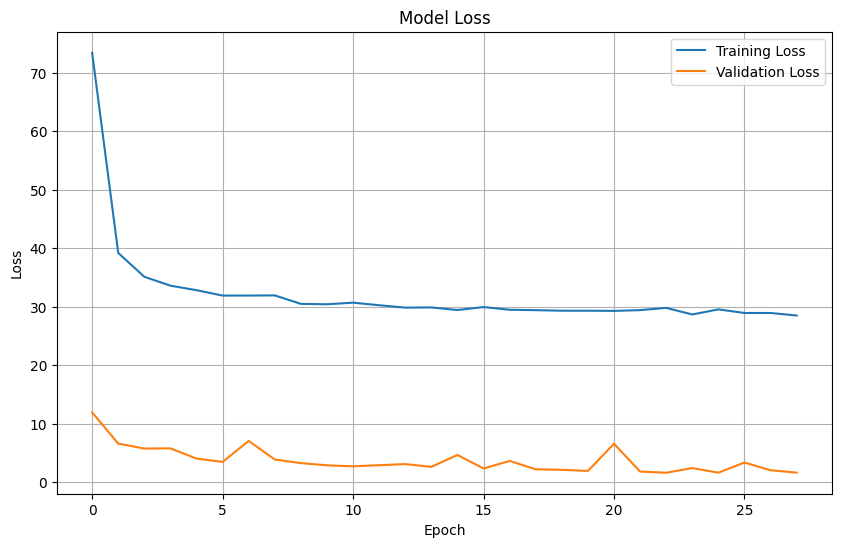

In [163]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [164]:
mlp_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 128)               1152      
                                                                 
 dense_89 (Dense)            (None, 64)                8256      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 32)                2080      
                                                                 
 dense_92 (Dense)            (None, 32)                1056      
                                                                 
 dense_93 (Dense)            (None, 1)                 33        
                                                                 
Total params: 16737 (65.38 KB)
Trainable params: 1673

In [165]:
# # Test predictions over the entire test dataset
# X_test_copy = X_test.copy()  # Copy the test data to avoid modifying the original
# predictions = []

# # Loop through each sample in the test dataset
# for i in range(len(X_test_copy)):
#     # Extract the current sequence (8 time steps)
#     current_sequence = X_test_copy[i]  # Get the ith row
    
#     # Reshape it to the correct shape for prediction: (1, 8, 1)
#     current_sequence = current_sequence.reshape(1, current_sequence.shape[0], 1)
    
#     # Debugging print statements
#     print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
#     # Predict the next velocity based on the current sequence
#     next_velocity = mlp_model.predict(current_sequence, verbose=0) # verbose=0 : Silent mode - no output during training
    
#     # Append the predicted velocity to the predictions list
#     predictions.append(next_velocity[0, 0])
    
#     # Replace the original value in the test set with the predicted one
#     if i < len(X_test_copy) - 1:  # Prevent index out of range error
#         X_test_copy[i + 1, -1, 0] = next_velocity[0, 0]

# # Print the predicted velocities for the test dataset
# print("Predicted velocities for the test dataset are:", predictions)

# Test predictions over the entire test dataset
X_test_copy = X_test.copy()  # Copy the test data to avoid modifying the original
predictions = []

# Loop through each sample in the test dataset
for i in range(len(X_test_copy)):
    # Extract the current sequence (8 time steps)
    current_sequence = X_test_copy[i]  # Get the ith row
    
    # Reshape it to the correct shape for prediction: (1, 8)
    current_sequence = current_sequence.reshape(1, current_sequence.shape[0])  # Reshape to 2D
    
    # Debugging print statements
    print(f"i = {i}, current_sequence shape = {current_sequence.shape}")
    
    # Predict the next velocity based on the current sequence
    next_velocity = mlp_model.predict(current_sequence, verbose=0)  # verbose=0 : Silent mode - no output during training
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Replace the original value in the test set with the predicted one
    if i < len(X_test_copy) - 1:  # Prevent index out of range error
        X_test_copy[i + 1, -1] = next_velocity[0, 0]  # Update the last time step with predicted value

# Print the predicted velocities for the test dataset
print("Predicted velocities for the test dataset are:", predictions)

i = 0, current_sequence shape = (1, 8)
i = 1, current_sequence shape = (1, 8)
i = 2, current_sequence shape = (1, 8)
i = 3, current_sequence shape = (1, 8)
i = 4, current_sequence shape = (1, 8)
i = 5, current_sequence shape = (1, 8)
i = 6, current_sequence shape = (1, 8)
i = 7, current_sequence shape = (1, 8)
i = 8, current_sequence shape = (1, 8)
i = 9, current_sequence shape = (1, 8)
i = 10, current_sequence shape = (1, 8)
i = 11, current_sequence shape = (1, 8)
i = 12, current_sequence shape = (1, 8)
i = 13, current_sequence shape = (1, 8)
i = 14, current_sequence shape = (1, 8)
i = 15, current_sequence shape = (1, 8)
i = 16, current_sequence shape = (1, 8)
i = 17, current_sequence shape = (1, 8)
i = 18, current_sequence shape = (1, 8)
i = 19, current_sequence shape = (1, 8)
i = 20, current_sequence shape = (1, 8)
i = 21, current_sequence shape = (1, 8)
i = 22, current_sequence shape = (1, 8)
i = 23, current_sequence shape = (1, 8)
i = 24, current_sequence shape = (1, 8)
i = 25, cu

i = 206, current_sequence shape = (1, 8)
i = 207, current_sequence shape = (1, 8)
i = 208, current_sequence shape = (1, 8)
i = 209, current_sequence shape = (1, 8)
i = 210, current_sequence shape = (1, 8)
i = 211, current_sequence shape = (1, 8)
i = 212, current_sequence shape = (1, 8)
i = 213, current_sequence shape = (1, 8)
i = 214, current_sequence shape = (1, 8)
i = 215, current_sequence shape = (1, 8)
i = 216, current_sequence shape = (1, 8)
i = 217, current_sequence shape = (1, 8)
i = 218, current_sequence shape = (1, 8)
i = 219, current_sequence shape = (1, 8)
i = 220, current_sequence shape = (1, 8)
i = 221, current_sequence shape = (1, 8)
i = 222, current_sequence shape = (1, 8)
i = 223, current_sequence shape = (1, 8)
i = 224, current_sequence shape = (1, 8)
i = 225, current_sequence shape = (1, 8)
i = 226, current_sequence shape = (1, 8)
i = 227, current_sequence shape = (1, 8)
i = 228, current_sequence shape = (1, 8)
i = 229, current_sequence shape = (1, 8)
i = 230, current

i = 408, current_sequence shape = (1, 8)
i = 409, current_sequence shape = (1, 8)
i = 410, current_sequence shape = (1, 8)
i = 411, current_sequence shape = (1, 8)
i = 412, current_sequence shape = (1, 8)
i = 413, current_sequence shape = (1, 8)
i = 414, current_sequence shape = (1, 8)
i = 415, current_sequence shape = (1, 8)
i = 416, current_sequence shape = (1, 8)
i = 417, current_sequence shape = (1, 8)
i = 418, current_sequence shape = (1, 8)
i = 419, current_sequence shape = (1, 8)
i = 420, current_sequence shape = (1, 8)
i = 421, current_sequence shape = (1, 8)
i = 422, current_sequence shape = (1, 8)
i = 423, current_sequence shape = (1, 8)
i = 424, current_sequence shape = (1, 8)
i = 425, current_sequence shape = (1, 8)
i = 426, current_sequence shape = (1, 8)
i = 427, current_sequence shape = (1, 8)
i = 428, current_sequence shape = (1, 8)
i = 429, current_sequence shape = (1, 8)
i = 430, current_sequence shape = (1, 8)
i = 431, current_sequence shape = (1, 8)
i = 432, current

i = 610, current_sequence shape = (1, 8)
i = 611, current_sequence shape = (1, 8)
i = 612, current_sequence shape = (1, 8)
i = 613, current_sequence shape = (1, 8)
i = 614, current_sequence shape = (1, 8)
i = 615, current_sequence shape = (1, 8)
i = 616, current_sequence shape = (1, 8)
i = 617, current_sequence shape = (1, 8)
i = 618, current_sequence shape = (1, 8)
i = 619, current_sequence shape = (1, 8)
i = 620, current_sequence shape = (1, 8)
i = 621, current_sequence shape = (1, 8)
i = 622, current_sequence shape = (1, 8)
i = 623, current_sequence shape = (1, 8)
i = 624, current_sequence shape = (1, 8)
i = 625, current_sequence shape = (1, 8)
i = 626, current_sequence shape = (1, 8)
i = 627, current_sequence shape = (1, 8)
i = 628, current_sequence shape = (1, 8)
i = 629, current_sequence shape = (1, 8)
i = 630, current_sequence shape = (1, 8)
i = 631, current_sequence shape = (1, 8)
i = 632, current_sequence shape = (1, 8)
i = 633, current_sequence shape = (1, 8)
i = 634, current

i = 810, current_sequence shape = (1, 8)
i = 811, current_sequence shape = (1, 8)
i = 812, current_sequence shape = (1, 8)
i = 813, current_sequence shape = (1, 8)
i = 814, current_sequence shape = (1, 8)
i = 815, current_sequence shape = (1, 8)
i = 816, current_sequence shape = (1, 8)
i = 817, current_sequence shape = (1, 8)
i = 818, current_sequence shape = (1, 8)
i = 819, current_sequence shape = (1, 8)
i = 820, current_sequence shape = (1, 8)
i = 821, current_sequence shape = (1, 8)
i = 822, current_sequence shape = (1, 8)
i = 823, current_sequence shape = (1, 8)
i = 824, current_sequence shape = (1, 8)
i = 825, current_sequence shape = (1, 8)
i = 826, current_sequence shape = (1, 8)
i = 827, current_sequence shape = (1, 8)
i = 828, current_sequence shape = (1, 8)
i = 829, current_sequence shape = (1, 8)
i = 830, current_sequence shape = (1, 8)
i = 831, current_sequence shape = (1, 8)
i = 832, current_sequence shape = (1, 8)
i = 833, current_sequence shape = (1, 8)
i = 834, current

i = 1013, current_sequence shape = (1, 8)
i = 1014, current_sequence shape = (1, 8)
i = 1015, current_sequence shape = (1, 8)
i = 1016, current_sequence shape = (1, 8)
i = 1017, current_sequence shape = (1, 8)
i = 1018, current_sequence shape = (1, 8)
i = 1019, current_sequence shape = (1, 8)
i = 1020, current_sequence shape = (1, 8)
i = 1021, current_sequence shape = (1, 8)
i = 1022, current_sequence shape = (1, 8)
i = 1023, current_sequence shape = (1, 8)
i = 1024, current_sequence shape = (1, 8)
i = 1025, current_sequence shape = (1, 8)
i = 1026, current_sequence shape = (1, 8)
i = 1027, current_sequence shape = (1, 8)
i = 1028, current_sequence shape = (1, 8)
i = 1029, current_sequence shape = (1, 8)
i = 1030, current_sequence shape = (1, 8)
i = 1031, current_sequence shape = (1, 8)
i = 1032, current_sequence shape = (1, 8)
i = 1033, current_sequence shape = (1, 8)
i = 1034, current_sequence shape = (1, 8)
i = 1035, current_sequence shape = (1, 8)
i = 1036, current_sequence shape =

i = 1211, current_sequence shape = (1, 8)
i = 1212, current_sequence shape = (1, 8)
i = 1213, current_sequence shape = (1, 8)
i = 1214, current_sequence shape = (1, 8)
i = 1215, current_sequence shape = (1, 8)
i = 1216, current_sequence shape = (1, 8)
i = 1217, current_sequence shape = (1, 8)
i = 1218, current_sequence shape = (1, 8)
i = 1219, current_sequence shape = (1, 8)
i = 1220, current_sequence shape = (1, 8)
i = 1221, current_sequence shape = (1, 8)
i = 1222, current_sequence shape = (1, 8)
i = 1223, current_sequence shape = (1, 8)
i = 1224, current_sequence shape = (1, 8)
i = 1225, current_sequence shape = (1, 8)
i = 1226, current_sequence shape = (1, 8)
i = 1227, current_sequence shape = (1, 8)
i = 1228, current_sequence shape = (1, 8)
i = 1229, current_sequence shape = (1, 8)
i = 1230, current_sequence shape = (1, 8)
i = 1231, current_sequence shape = (1, 8)
i = 1232, current_sequence shape = (1, 8)
i = 1233, current_sequence shape = (1, 8)
i = 1234, current_sequence shape =

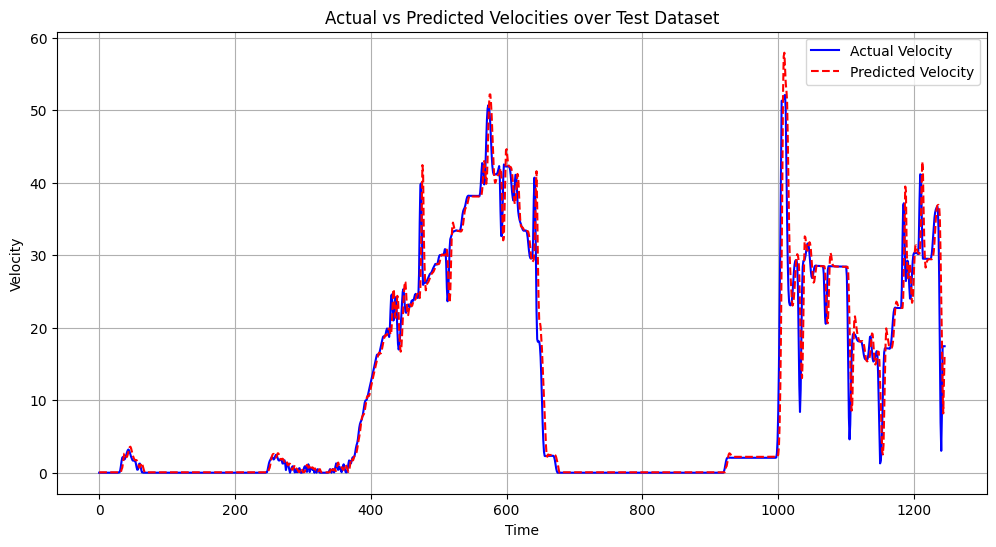

In [160]:
# Assuming y_test contains the true velocities
true_velocities = y_test

# Assuming predictions contain the predicted velocities
predicted_velocities = np.array(predictions)  # Convert to numpy array if it's not already

# Create time indices for the test dataset
time_indices = np.arange(len(true_velocities))

# Create a DataFrame to store the actual and predicted velocities with the time indices
results_df = pd.DataFrame({
    'Time': time_indices,
    'Actual Velocity': true_velocities,
    'Predicted Velocity': predicted_velocities
})

# Plotting the actual and predicted velocities
plt.figure(figsize=(12, 6))

# Plot the actual velocities
plt.plot(results_df['Time'], results_df['Actual Velocity'], label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(results_df['Time'], results_df['Predicted Velocity'], label='Predicted Velocity', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities over Test Dataset')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [161]:
# Ensure both DataFrames have identical rows and columns
assert true_velocities.shape == predicted_velocities.shape, "Datasets must have the same shape!"

# Calculate RMSE using the mathematical formula
def calculate_rmse(true_values, predicted_values):
    # Calculate the mean square error
    mse = np.mean((true_values - predicted_values) ** 2)
    # Take the square root of the mean square error to get RMSE
    rmse = np.sqrt(mse)
    return rmse

# Apply RMSE calculation on all values
rmse = calculate_rmse(true_velocities, predicted_velocities)

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 3.2242901712433696


In [448]:
### ADDITIONAL LINE OF CODES ###

# Use the last known sequence from the test set for prediction
last_sequence = X_test[-1]

# Number of future steps to predict
n_steps = 5
predictions = []

for _ in range(n_steps):
    # Predict the next velocity
    next_velocity = lstm_model.predict(last_sequence.reshape(1, last_sequence.shape[0], 1), verbose=0)
    
    # Append the predicted velocity to the predictions list
    predictions.append(next_velocity[0, 0])
    
    # Update the sequence: remove the oldest velocity and add the predicted one
    last_sequence = np.append(last_sequence[1:], next_velocity[0, 0]).reshape(-1, 1)

# Print the predicted velocities for the next 5 steps
print("Predicted velocities for the next 5 time steps:", predictions)

# Optionally convert the predictions into a DataFrame or append them to an existing DataFrame
predicted_df = pd.DataFrame(predictions, columns=['Predicted Velocity'])

print(predicted_df)

Predicted velocities for the next 5 time steps: [12.344036, 12.847734, 8.244192, 6.273425, 5.711837]
   Predicted Velocity
0           12.344036
1           12.847734
2            8.244192
3            6.273425
4            5.711837


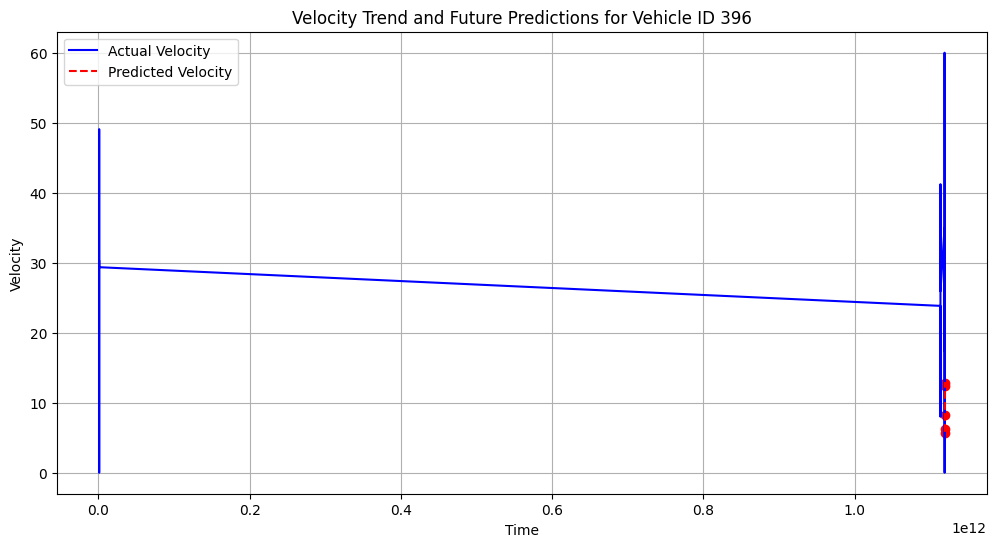

In [447]:
# the last known time in your dataset is `last_known_time`
last_known_time = single_vehicle_data['Global_Time'].iloc[-1]

# Generate future time steps (1 timestep in future)
future_time = np.arange(last_known_time + 1, last_known_time + 1 + len(predictions))

# Append these predictions to the original time and velocity arrays for plotting
extended_time = np.append(time, future_time)
extended_velocity = np.append(velocity, predictions)

# Plot the original velocity trend
plt.figure(figsize=(12, 6))
plt.plot(time, velocity, label='Actual Velocity', color='blue')

# Plot the predicted velocities
plt.plot(future_time, predictions, label='Predicted Velocity', color='red', linestyle='--')

# Highlight the predicted points with markers
plt.scatter(future_time, predictions, color='red', marker='o')

# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity Trend and Future Predictions for Vehicle ID {}'.format(specific_vehicle_id))
plt.legend()
plt.grid(True)
plt.show()
